In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from src.train import tonfig
DEVICE = torch.device("cuda")

# Test Model

## Forward pass

In [2]:
from src.model import (
    MAGNET,
    TransformerDecoder,
    monfig
)
from src.preprocess_ops import PreProOps
from src.music_bench import (
    MAX_SEC, 
    shuffle_preserve_order, 
    QCODING_LEN,
)
from src.train import PreProDataset

In [3]:
preprocess_ops = PreProOps(
    max_sec=QCODING_LEN,
    print_info=True,
    device=DEVICE.type,
    compile=False
)

/home/vvy/Desktop/repos/MAGNeT/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
cond_tok = preprocess_ops.tokenize(
    ["Hey, how are you doing today?", "I'm doing great, thanks for asking!"],
)
cond_tok["input_ids"], cond_tok["input_ids"].shape

(tensor([[9459,    6,  149,   33,   25,  692,  469,   58,    1,    0,    0],
         [  27,   31,   51,  692,  248,    6, 2049,   21, 3558,   55,    1]]),
 torch.Size([2, 11]))

In [5]:
cond_tok["attention_mask"], cond_tok["attention_mask"].shape

(tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 torch.Size([2, 11]))

In [6]:
cond_tensor = preprocess_ops.get_conditioned_tensor(cond_tok)
cond_tensor, cond_tensor.shape

(tensor([[[ 0.0800, -0.0364, -0.1036,  ..., -0.2104, -0.1398, -0.1040],
          [ 0.1597,  0.1182, -0.2388,  ..., -0.0835, -0.0980, -0.1727],
          [-0.0957,  0.0359,  0.2814,  ..., -0.0333,  0.2108, -0.0099],
          ...,
          [ 0.0439,  0.0737, -0.0768,  ..., -0.0767,  0.0265, -0.0010],
          [ 0.1242, -0.0134,  0.2866,  ..., -0.0929,  0.0955, -0.1671],
          [ 0.1435,  0.0110,  0.2968,  ..., -0.0488,  0.0799, -0.1604]],
 
         [[ 0.1370, -0.1287,  0.1268,  ...,  0.1340, -0.1318, -0.0488],
          [ 0.1182,  0.1226, -0.1888,  ...,  0.0424,  0.0515, -0.2712],
          [-0.0215,  0.1384, -0.2083,  ...,  0.2155, -0.2186,  0.0929],
          ...,
          [-0.1775, -0.0603,  0.2032,  ...,  0.1287, -0.0658,  0.2017],
          [-0.0896,  0.0004, -0.0261,  ...,  0.0706,  0.0023, -0.1165],
          [ 0.0512,  0.0576, -0.0301,  ...,  0.0092,  0.0330, -0.0518]]],
        device='cuda:0'),
 torch.Size([2, 11, 512]))

In [7]:
prepro_ds = iter(PreProDataset(
    wav_paths=[["data/MusicBench/datashare/data_aug2/_0-2meOf9qY_4.wav", "data/MusicBench/datashare/data_aug2/zzNdwF40ID8_3.wav"],
               ["data/MusicBench/datashare/data_aug2/_0-2meOf9qY_4.wav", "data/MusicBench/datashare/data_aug2/zzNdwF40ID8_3.wav"]],
    texts=["Hey, how are you doing today?", "I'm doing great, thanks for asking!"],
    audio_pad_id=1024,
    device=DEVICE.type,
    preprocess_ops=preprocess_ops,
    qcoding_len=QCODING_LEN,
).iter_batches())

In [8]:
a = next(prepro_ds)
a[0]["qcode"].shape, a[0]["mask"].shape, a

(torch.Size([2, 4, 750]),
 torch.Size([2, 4, 750]),
 ({'qcode': tensor([[[  62,   62,   62,  ..., 1024, 1024, 1024],
            [ 913,  424,  424,  ..., 1024, 1024, 1024],
            [ 786,  786,  786,  ..., 1024, 1024, 1024],
            [ 673,  673,  673,  ..., 1024, 1024, 1024]],
   
           [[ 131,  224,  310,  ..., 1024, 1024, 1024],
            [ 422,    0,  653,  ..., 1024, 1024, 1024],
            [ 316,  798,  798,  ..., 1024, 1024, 1024],
            [ 721,  818,  721,  ..., 1024, 1024, 1024]]], device='cuda:0'),
   'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False]],
   
           [[ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,

In [9]:
cond_tensor, cond_tensor.shape

(tensor([[[ 0.0800, -0.0364, -0.1036,  ..., -0.2104, -0.1398, -0.1040],
          [ 0.1597,  0.1182, -0.2388,  ..., -0.0835, -0.0980, -0.1727],
          [-0.0957,  0.0359,  0.2814,  ..., -0.0333,  0.2108, -0.0099],
          ...,
          [ 0.0439,  0.0737, -0.0768,  ..., -0.0767,  0.0265, -0.0010],
          [ 0.1242, -0.0134,  0.2866,  ..., -0.0929,  0.0955, -0.1671],
          [ 0.1435,  0.0110,  0.2968,  ..., -0.0488,  0.0799, -0.1604]],
 
         [[ 0.1370, -0.1287,  0.1268,  ...,  0.1340, -0.1318, -0.0488],
          [ 0.1182,  0.1226, -0.1888,  ...,  0.0424,  0.0515, -0.2712],
          [-0.0215,  0.1384, -0.2083,  ...,  0.2155, -0.2186,  0.0929],
          ...,
          [-0.1775, -0.0603,  0.2032,  ...,  0.1287, -0.0658,  0.2017],
          [-0.0896,  0.0004, -0.0261,  ...,  0.0706,  0.0023, -0.1165],
          [ 0.0512,  0.0576, -0.0301,  ...,  0.0092,  0.0330, -0.0518]]],
        device='cuda:0'),
 torch.Size([2, 11, 512]))

In [10]:
magnet_model = MAGNET(
    model=TransformerDecoder(monfig),
    config=monfig
).to(DEVICE)

In [11]:
out = magnet_model(a[0]["qcode"], cond_tensor)
out.shape

torch.Size([2, 4, 750, 1024])

# Test Training:
## Try Overfiting a lil batch

In [12]:
from src.music_bench import AUDIO_TXT_PATH, ioPathTextDs
from src.train import PreProDataset, MagnetTrainer
from src.utils.lr_scheduler import CosineDecayWithWarmup

import time

In [17]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[4:5],
    texts=y_train[4:5],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 437,   20,  531,  ...,  531,  613,  713],
           [ 397,  792,  463,  ...,  695,  537,  925],
           [  29,   87,  838,  ...,  952,  253,  320],
           [ 711,  236,  120,  ...,  409,  377,  197]],
  
          [[  59,   59,   59,  ...,  428,  192, 1008],
           [ 245,  367,  529,  ...,  851,  851,  297],
           [ 828,   66,  130,  ...,  711,  458,  357],
           [ 129,  707,  551,  ...,  341,  584,  388]]], device='cuda:0'),
  'mask': tensor([[[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]],
  
          [[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]]], device='cuda:0')},
 ['This country blues instrumental song incorporates a

In [19]:
print(sum(p.numel() for p in magnet_model.parameters() if p.requires_grad)/1e6, "Million Parameters")

37.833728 Million Parameters


In [20]:
magnet_trainer = MagnetTrainer(
    magnet_model=magnet_model,
    preprocess_ops=preprocess_ops,
    config=tonfig
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=tonfig.warmup_steps,
    max_learning_rate=tonfig.max_learning_rate,
    decay_steps=tonfig.decay_steps,
    min_learning_rate=tonfig.min_learning_rate
)

ctx = (
        torch.autocast(
                device_type="cuda" if "cuda" in DEVICE.type else "cpu",
                dtype={"bfloat16": torch.bfloat16,
                       "float16" : torch.float16}[tonfig.dtype]
        )
    )

scaler = torch.cuda.amp.GradScaler(enabled=(tonfig.dtype=="float16"))

optimizer = magnet_model.configure_optimizers(
    weight_decay=tonfig.weight_decay,
    learning_rate=5e-4,
    betas=(tonfig.beta1, tonfig.beta2),
    device_type="cuda" if "cuda" in DEVICE.type else "cpu"
)

In [21]:
def test_train():
    losses, accuracies = [], []
    audio_input, cond_text = next(train_iterator)

    print("Training about to start...")
    t0 = time.time()
    for step in range(0, 2000):
        # set learning rate for all params
        lr = 1e-4
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # gradient accumulation step
        for mini_step in range(tonfig.num_grad_accumalation_steps):
            with ctx:
                loss, accuracy = magnet_trainer.mini_train_step(
                    audio_input=audio_input, padded_cond_str=cond_text
                )
                loss /= tonfig.num_grad_accumalation_steps
                # async prefetch immediately
                audio_input, cond_text = next(train_iterator)

            # keeps on scaling and adding gradients when calling backward
            scaler.scale(loss).backward()

        if tonfig.clipnorm is not None:
            # unscale the gradients
            scaler.unscale_(optimizer)
            # clips gradients in-place to grad norm
            nn.utils.clip_grad_norm_(magnet_model.parameters(), max_norm=tonfig.clipnorm)

        # calls unscale to the optimizer unless already called, checks for infs and nans as a part of unscale_
        # calls optimizer.step on unscaled grads if no infs and nans else optimizer.step is skipped
        scaler.step(optimizer)
        # Update the scale factor
        scaler.update()

        # flush grads to save memory
        optimizer.zero_grad(set_to_none=True)

        # some logging
        t1 = time.time()
        dt = t1-t0
        t0 = t1
        if step % tonfig.log_interval == 0:
            # multiply as loss was scaled for gradient accumulation
            lossf = loss.item() * tonfig.num_grad_accumalation_steps
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || Accuracy: {accuracy:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
            )
            losses.append(lossf); accuracies.append(accuracy.cpu().item())
    return losses, accuracies

losses, accuracies = test_train()

Training about to start...
| Step: 0 || Loss: 7.1162 || Accuracy: 0.0023 || LR: 1.000000e-04 || dt: 316.91ms |
| Step: 1 || Loss: 7.1735 || Accuracy: 0.0010 || LR: 1.000000e-04 || dt: 57.14ms |
| Step: 2 || Loss: 7.1363 || Accuracy: 0.0023 || LR: 1.000000e-04 || dt: 50.26ms |
| Step: 3 || Loss: 7.0939 || Accuracy: 0.0097 || LR: 1.000000e-04 || dt: 46.47ms |
| Step: 4 || Loss: 7.0266 || Accuracy: 0.0183 || LR: 1.000000e-04 || dt: 48.02ms |
| Step: 5 || Loss: 6.8302 || Accuracy: 0.0197 || LR: 1.000000e-04 || dt: 47.65ms |
| Step: 6 || Loss: 6.7761 || Accuracy: 0.0307 || LR: 1.000000e-04 || dt: 47.30ms |
| Step: 7 || Loss: 6.5422 || Accuracy: 0.0427 || LR: 1.000000e-04 || dt: 46.42ms |
| Step: 8 || Loss: 6.6599 || Accuracy: 0.0317 || LR: 1.000000e-04 || dt: 44.22ms |
| Step: 9 || Loss: 6.8017 || Accuracy: 0.0357 || LR: 1.000000e-04 || dt: 45.79ms |
| Step: 10 || Loss: 6.7645 || Accuracy: 0.0360 || LR: 1.000000e-04 || dt: 44.58ms |
| Step: 11 || Loss: 6.7652 || Accuracy: 0.0390 || LR: 1.00

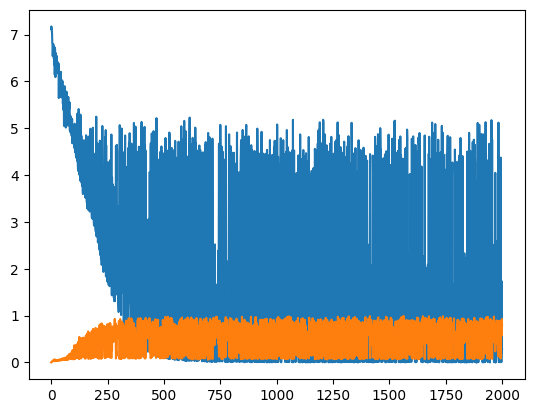

In [22]:
plt.plot(losses)
plt.plot(accuracies)
plt.show()

## Generate